In [1]:
%load_ext autoreload
%autoreload 2

from base64 import b64encode
import copy
from datetime import datetime
import getopt
import io
from io import BytesIO
import os
import sys


import json

import types

# standard numeric/scientific libraries
import numpy as np
import pandas as pd
import scipy as sp
import scipy.signal as sps
import scipy.fftpack as fftpack 

# plotting
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# image display
from PIL import Image
import IPython.display 
from IPython.display import HTML

#internal libraries which may or may not get used
import fdls
from lddutils import *

import lddecode_core as ldd

In [15]:
matplotlib.rc('figure', figsize=(20, 12))


In [2]:
outname = 'devbook'
system = 'NTSC'
foutput = False
loader = load_packed_data_4_40

filename = '/mnt4/dd/he010_side1_6x_2018-10-09_21-42-14.lds'
firstframe = 0
req_frames = 3

In [3]:
freader = load_packed_data_4_40

fd = open('/mnt4/dd/he010_side1_6x_2018-10-09_21-42-14.lds', 'rb')
#fd.seek((40*1000*1000)*2*60)

data = freader(fd, (40*1000*1000)*1200, (40*1000*1000))

In [4]:
def efmdemod(indata, start, length, blocklen = 16384, blockcut = 2048):
    end = int(start + length) + 1
    start = int(start - blockcut) if (start > blockcut) else 0

    # set a placeholder
    output = None

    blockcut_end = blockcut
    
    blocklen_overlap = blocklen - blockcut - blockcut_end
    for i in range(start, end, blocklen_overlap):
        # XXX: process last block with 0 padding
        if (i + blocklen_overlap) > end:
            break

        filtered_efm = do_efmfilter(indata[i:i+blocklen])
            
        # if the output hasn't been created yet, do it now using the 
        # data types returned by dodemod (should be faster than multiple
        # allocations...)
        if output is None:
            output = np.zeros(end - start + 1, dtype=filtered_efm.dtype)

        if i - start + (blocklen - blockcut) > len(output):
            copylen = len(output) - (i - start)
        else:
            copylen = blocklen - blockcut - blockcut_end

        output_slice = slice(i - start, i - start + copylen)
        tmp_slice = slice(blockcut, blockcut + copylen)

        #print(output_slice, blocklen_overlap)
        
        output[output_slice] = filtered_efm[tmp_slice]
        
    return output[:output_slice.stop]

In [5]:
efmFilter_b = [0.002811997668622127, 0.004557434177095733, 0.005518081763120638, 0.006175434988371297,
        0.007079542302379131, 0.007762746564588261, 0.007195457153986951, 0.004856513521712550,
        830.5207151564147810E-6, -0.004778562707971237, -0.011982337787676704, -0.020620652183251653,
       -0.030313333572191556, -0.040603187005666612, -0.050923073987327538, -0.060516949563439962,
       -0.068546464145567254, -0.074232214244951744, -0.076886606768788085, -0.075966051373979687,
       -0.071190271468117655, -0.062596043962852732, -0.050510748183213161, -0.035543389044287388,
       -0.018571164687106789, -653.7572477720859750E-6, 0.017076103040008714, 0.033491741568629191,
        0.047560393829158804, 0.058451726209266315, 0.065610957042443047, 0.068787227432726056,
        0.068052927749701272, 0.063800948413328271, 0.056691533146975850, 0.047573385532196255,
        0.037405276759632830, 0.027164400458192961, 0.017743654186943611, 0.009870181642090168,
        0.004052704260208225, 544.6177383273721940E-6, -667.1955887800581880E-6, 165.1444186576358670E-6,
        0.002601820774369020, 0.006075778653150664, 0.009965935705131752, 0.013676514558850801,
        0.016702483466449127, 0.018675612904669636, 0.019395327506222131, 0.018837755091170524,
        0.017137913326564228, 0.014554762572554125, 0.011427836596406824, 0.008126164613403961,
        0.004996232601002520, 0.002320620946358973, 290.5097959689243230E-6, -0.001009070788039298,
        -0.001598148724027520, -0.001584492210927387, -0.001136622115179061, -452.5692444180374420E-6,
        273.0780338995041350E-6, 878.5749907962782570E-6, 0.001255201534195653, 0.001356950513019374,
        0.001200086984625413, 852.4978004878322510E-6, 415.1503402529320400E-6]

efmFilter_b.reverse()

In [68]:
efmfilter = filtfft((efmFilter_b, [1.0]), 16384)

def do_efmfilter(data):
    floatdata = np.array(data, dtype=np.float)
    return floatdata

rv_nofilt = efmdemod(data, 0, 20*1000*1000)
len(rv_nofilt)

outfd = open('tmp.nofilt', 'wb')
outfd.write(data[:len(rv_nofilt)].astype(np.int16))

39985152

In [39]:
!ld-lds-converter -p -i tmp.nofilt.filt.raw -o tmp.nofilt.lds
!tools/ld-ldstoefm/ld-ldstoefm -f -n -s tmp.nofilt.lds tmp.origfilt
!ld-lds-converter -p -i tmp.origfilt -o tmp.origfilt.lds
!tools/ld-ldstoefm/ld-ldstoefm -f -e tmp.nofilt.lds tmp.efm
!tools/ld-process-efm/ld-process-efm --input tmp.efm --audio tmp.pcm

Info: Writing output as a 16-bit signed sample of the filter output
Info: Using floating-point filter processing
Info: Processed 100%
Info: Processing complete
Info: Using floating-point filter processing
Info: Processed 100%
Info: Processing complete
Info: Processed 21% of the input EFM
Info: Processed 42% of the input EFM
Info: Processed 63% of the input EFM
Info: Processed 84% of the input EFM
Info: Processed 100% of the input EFM
Info: EFM processing:
Info:   Total number of sections processed = 30
Info:   Q Mode 0 sections = 0 (Data)
Info:   Q Mode 1 sections = 0 (CD Audio)
Info:   Q Mode 2 sections = 0 (Disc ID)
Info:   Q Mode 3 sections = 0 (Track ID)
Info:   Q Mode 4 sections = 30 (Non-CD Audio)
Info:   Sections with failed Q CRC = 0
Info: 
Info: EFM to F3 Frame converter:
Info:   Total number of F3 Frames = 3082
Info:   of which 3078 were 588 bits and 4 were invalid lengths
Info:   Lost frame sync 0 times
Info: 
Info: C1 Level error correction:
Info:   Total number of C1s proc

In [40]:
goodfilt = open('tmp.origfilt', 'rb')
inbuf = goodfilt.read()
gooddata = np.frombuffer(inbuf, 'int16', len(inbuf) // 2)

In [12]:
efmfilter = filtfft((efmFilter_b, [1.0]), 16384)

def do_efmfilter(data):
    floatdata = np.array(data, dtype=np.float)
    
    fftdata = np.fft.fft(floatdata)
    output = np.fft.ifft(fftdata * efmfilter).real
    
    return output

rva = efmdemod(data, 0, 20*1000*1000)
len(rva)

19992576

In [69]:
efmfilter = filtfft((efmFilter_b, [1.0]), 16384)

def do_efmfilter(data):
    
    return sps.lfilter(efmFilter_b, [1.0], data) * 8

rv = efmdemod(data, 0, 20*1000*1000)
rv = np.clip(rv, -32760, 32760)
len(rv)

19992576

In [70]:
outfd = open('tmp.filt', 'wb')
outfd.write(rv.astype(np.int16))

!ld-lds-converter -p -i tmp.filt -o tmp.filt.lds
!tools/ld-ldstoefm/ld-ldstoefm -f -e tmp.filt.lds tmp.efm
!tools/ld-process-efm/ld-process-efm --input tmp.efm --audio tmp.pcm

Info: Using floating-point filter processing
Info: Processed 83%
Info: Processing complete
Info: Processed 21% of the input EFM
Info: Processed 42% of the input EFM
Info: Processed 63% of the input EFM
Info: Processed 84% of the input EFM
Info: Processed 99% of the input EFM
Info: EFM processing:
Info:   Total number of sections processed = 30
Info:   Q Mode 0 sections = 0 (Data)
Info:   Q Mode 1 sections = 0 (CD Audio)
Info:   Q Mode 2 sections = 0 (Disc ID)
Info:   Q Mode 3 sections = 0 (Track ID)
Info:   Q Mode 4 sections = 30 (Non-CD Audio)
Info:   Sections with failed Q CRC = 0
Info: 
Info: EFM to F3 Frame converter:
Info:   Total number of F3 Frames = 3081
Info:   of which 3077 were 588 bits and 4 were invalid lengths
Info:   Lost frame sync 0 times
Info: 
Info: C1 Level error correction:
Info:   Total number of C1s processed = 3080
Info:   of which 3067 passed and 13 failed
Info:   The C1 error correction recovered 299 corrupt C1s
Info:   The delay buffer was flushed 0 times
Inf

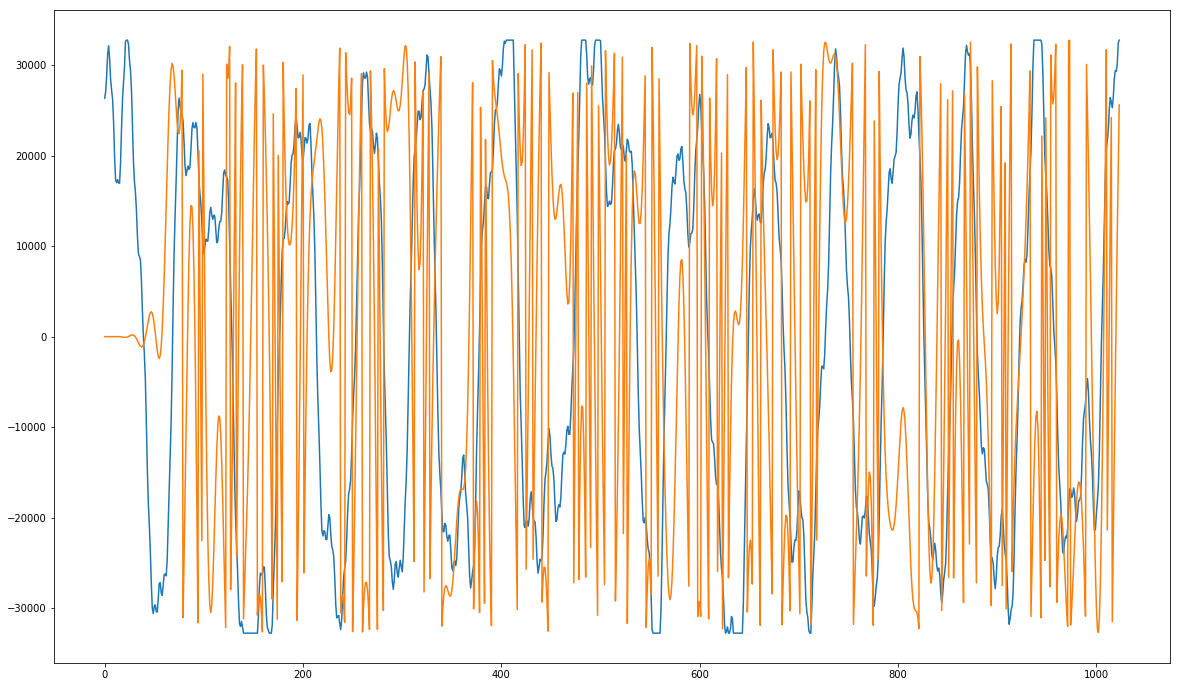

In [56]:
plt.plot(rv[0:1024])
plt.plot(gooddata[0:1024])

In [26]:
!ld-lds-converter -p -i tmp.nofilt -o tmp.nofilt.lds
!tools/ld-ldstoefm/ld-ldstoefm -f tmp.nofilt.lds tmp.efm
!tools/ld-process-efm/ld-process-efm --input tmp.efm --audio tmp.pcm

Info: Using floating-point filter processing
Info: Processed 83%
Info: Processing complete
Info: Processed 21% of the input EFM
Info: Processed 42% of the input EFM
Info: Processed 63% of the input EFM
Info: Processed 84% of the input EFM
Info: Processed 100% of the input EFM
Info: EFM processing:
Info:   Total number of sections processed = 30
Info:   Q Mode 0 sections = 0 (Data)
Info:   Q Mode 1 sections = 0 (CD Audio)
Info:   Q Mode 2 sections = 0 (Disc ID)
Info:   Q Mode 3 sections = 0 (Track ID)
Info:   Q Mode 4 sections = 30 (Non-CD Audio)
Info:   Sections with failed Q CRC = 0
Info: 
Info: EFM to F3 Frame converter:
Info:   Total number of F3 Frames = 3082
Info:   of which 3078 were 588 bits and 4 were invalid lengths
Info:   Lost frame sync 0 times
Info: 
Info: C1 Level error correction:
Info:   Total number of C1s processed = 3081
Info:   of which 3068 passed and 13 failed
Info:   The C1 error correction recovered 302 corrupt C1s
Info:   The delay buffer was flushed 0 times
In

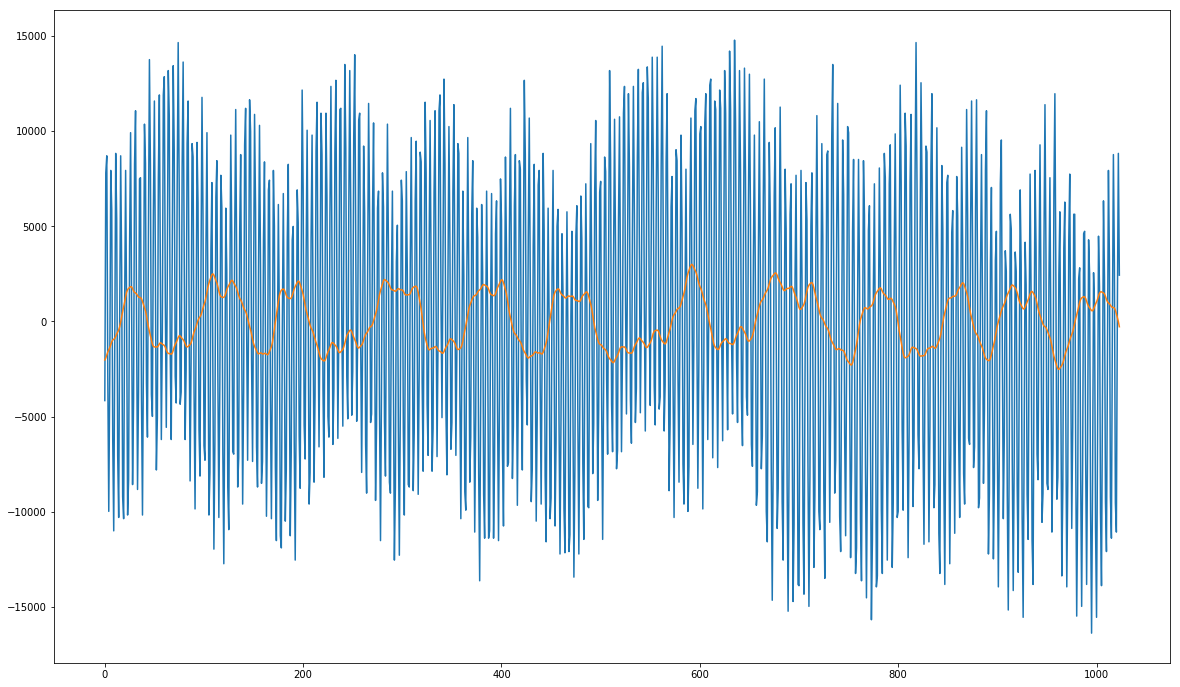

In [122]:
plt.plot(data[1024+0:1024+1024])
plt.plot(rv[0:1024])

In [90]:
rv

array([-4160,  7808,  8704, ..., -5824,  5376, 11904], dtype=int16)